In [52]:
# Calculating the Revenue from Energy Storage in the NEM
# By Charlie Dixon and Jack Oliver
# Version 1.0 - 8/10/23

# Import Libraries
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
sb.set()
import math
import os

#import FYP_functions as FYP 
%run FYP_functions_public.ipynb #second method is less scalable, but allows use of ipynb and doesn't require calling FYP before function handle

In [2]:
# Variables
regions = ['TAS', 'SA', 'QLD', 'NSW', 'VIC']
regions_aus = ['TAS', 'SA', 'QLD', 'NSW', 'VIC', 'AUS']

new_data = False # Queries server and appends new data to all dataframes if true, otherwise use old data
check = False # Check time intervals of formatted data for discrepencies
rte = 0.85
financial_year = False
years = 15

# Queries server for unformatted data from beginning of NEM til now
df_all_original, TAS, SA, QLD, NSW, VIC = queryServer(regions, new_data)
# Format to 30 min intervals, combinbing preformatted local data with unformatted server data 
TAS, SA, QLD, NSW, VIC = timeFormatting(regions, new_data, check)
AUS = combineRegions(regions)
# Calculate daily and monthly revenue for various hours of storage
TAS_DR, SA_DR, QLD_DR, NSW_DR, VIC_DR, AUS_DR, TAS_aMR, SA_aMR, QLD_aMR, NSW_aMR, VIC_aMR, AUS_aMR = dayMonthRevenue(regions_aus, rte, new_data)

# Outputs:
#TAS - 30 minute interval data
#TAS_DR - daily revenue calculation for n = 0.5 to n = 12 storage capacity
#TAS_aMR - average monthly revenye calculation for n = 0.5 to n = 12 storage capacity

TAS: resampled data exists. Calling from csv.
     CSV Last Date: 2023-09-19 23:30:00
SA: resampled data exists. Calling from csv.
     CSV Last Date: 2023-09-19 23:30:00
QLD: resampled data exists. Calling from csv.
     CSV Last Date: 2023-09-19 23:30:00
NSW: resampled data exists. Calling from csv.
     CSV Last Date: 2023-09-19 23:30:00
VIC: resampled data exists. Calling from csv.
     CSV Last Date: 2023-09-19 23:30:00


In [3]:
on_TAS, on_SA, on_QLD, on_NSW, on_VIC, on_AUS = openNEM(regions_aus)

TAS Calling OpenNEM from csv.
SA Calling OpenNEM from csv.
QLD Calling OpenNEM from csv.
NSW Calling OpenNEM from csv.
VIC Calling OpenNEM from csv.
AUS Calling OpenNEM from csv.


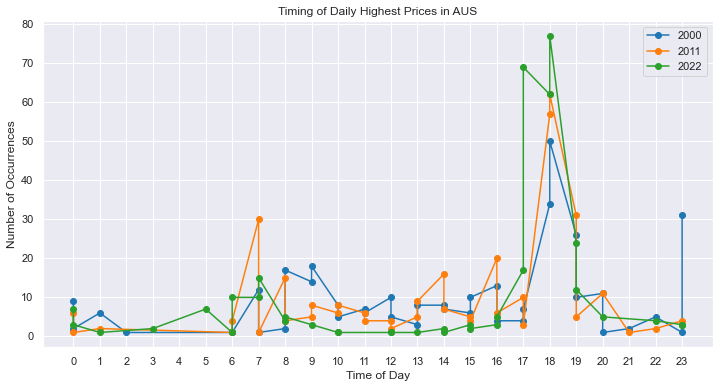

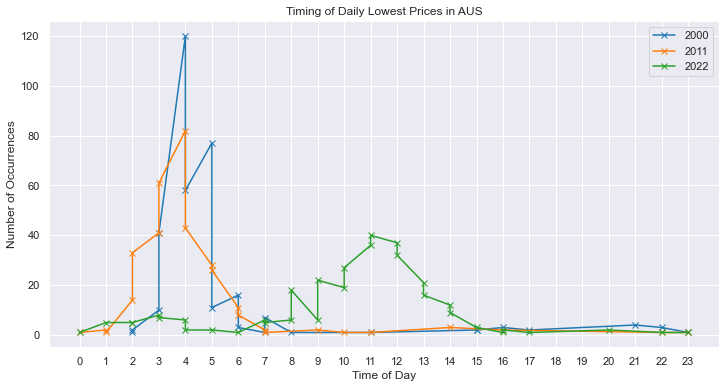

In [53]:
peakTimesPlot(['AUS'], [2000, 2011, 2022])

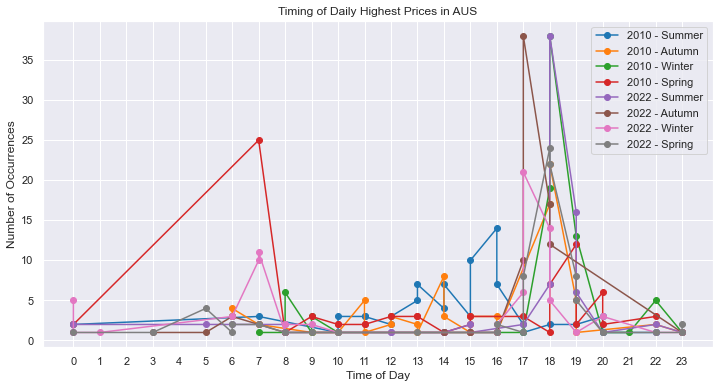

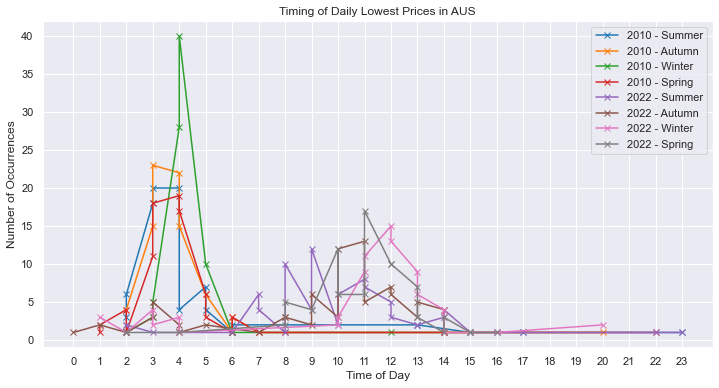

In [54]:
low_time_counts, highest_time_counts = peakTimesPlot3(['AUS'], [2010, 2022])

In [188]:
# Filter the data for the year 2022
low_season_2022 = low_time_counts[(low_time_counts['year'] == 2022)]

# Define a function to calculate the weighted mean time of day
def weighted_mean_time(x):
    total_weight = x['count'].sum()
    weighted_minutes = (x['hour'] * 60 + x['minute']) * x['count']
    return weighted_minutes.sum() / total_weight

# Group the data by season and calculate the mean time of day
mean_time_of_day_2022 = low_season_2022.groupby(['season']).apply(weighted_mean_time).reset_index(name='mean_time_minutes')

# Convert the mean time of day from minutes to hours and minutes
mean_time_of_day_2022['mean_time_hours'] = mean_time_of_day_2022['mean_time_minutes'] // 60
mean_time_of_day_2022['mean_time_minutes'] = mean_time_of_day_2022['mean_time_minutes'] % 60

# Print or use the resulting DataFrame
print(mean_time_of_day_2022)

   season  mean_time_minutes  mean_time_hours
0  Autumn          35.543478              9.0
1  Spring           9.230769             11.0
2  Summer          19.666667             10.0
3  Winter          54.456522             10.0


In [215]:
# Filter the data for the year 2022
low_season_2022 = low_time_counts[(low_time_counts['year'] <= 2017)]

# Define a function to calculate the weighted mean time of day
def weighted_mean_time(x):
    total_weight = x['count'].sum()
    weighted_minutes = (x['hour'] * 60 + x['minute']) * x['count']
    return weighted_minutes.sum() / total_weight

# Group the data by season and calculate the mean time of day
mean_time_of_day_2022 = low_season_2022.groupby(['season']).apply(weighted_mean_time).reset_index(name='mean_time_minutes')

# Convert the mean time of day from minutes to hours and minutes
mean_time_of_day_2022['mean_time_hours'] = mean_time_of_day_2022['mean_time_minutes'] // 60
mean_time_of_day_2022['mean_time_minutes'] = mean_time_of_day_2022['mean_time_minutes'] % 60

# Print or use the resulting DataFrame
print(mean_time_of_day_2022)

   season  mean_time_minutes  mean_time_hours
0  Autumn          38.890160              4.0
1  Spring          47.871602              4.0
2  Summer           9.534483              4.0
3  Winter           2.643021              5.0


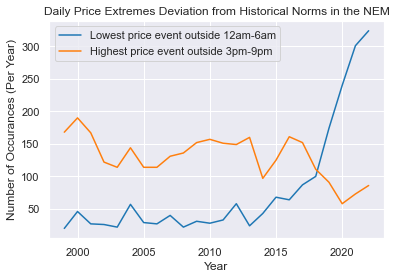

In [55]:
# Filter the DataFrame to include only the rows where the lowest price occurred
lowest_price_occurred = low_time_counts[low_time_counts['count'] > 0]
highest_price_occurred = highest_time_counts[highest_time_counts['count'] > 0]

# Extract year, hour, and minute from the timestamps
lowest_price_occurred['year'] = pd.to_numeric(lowest_price_occurred['year'])
lowest_price_occurred['hour'] = pd.to_numeric(lowest_price_occurred['hour'])
lowest_price_occurred['minute'] = pd.to_numeric(lowest_price_occurred['minute'])

highest_price_occurred['year'] = pd.to_numeric(highest_price_occurred['year'])
highest_price_occurred['hour'] = pd.to_numeric(highest_price_occurred['hour'])
highest_price_occurred['minute'] = pd.to_numeric(highest_price_occurred['minute'])

# Filter rows where the hour is greater than or equal to 6 and less than 24 (midnight)
after_6am = lowest_price_occurred[(lowest_price_occurred['hour'] >= 6) & (lowest_price_occurred['hour'] < 24)]
a3pm_9pm = highest_price_occurred[(highest_price_occurred['hour'] >= 21) | (highest_price_occurred['hour'] < 15)]

years = range(1999, 2023)
b = []
d = []
for year in years:
    a = after_6am[after_6am['year'] == year]['count'].sum()
    c = a3pm_9pm[a3pm_9pm['year'] == year]['count'].sum()

    b.append(a)
    d.append(c)
plt.plot(years, b, label = 'Lowest price event outside 12am-6am')
plt.plot(years, d, label = 'Highest price event outside 3pm-9pm')

plt.title('Daily Price Extremes Deviation from Historical Norms in the NEM')
plt.xlabel('Year')
plt.ylabel('Number of Occurances (Per Year)')
plt.legend()

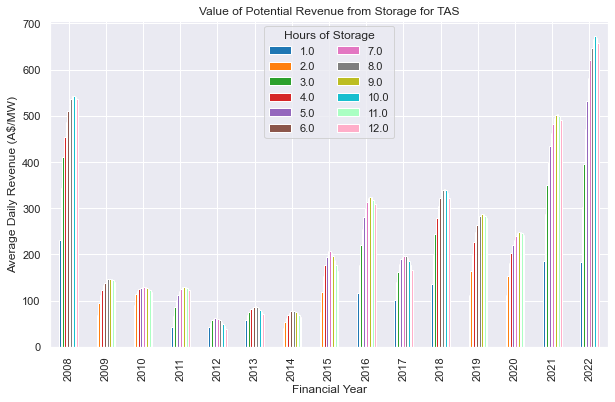

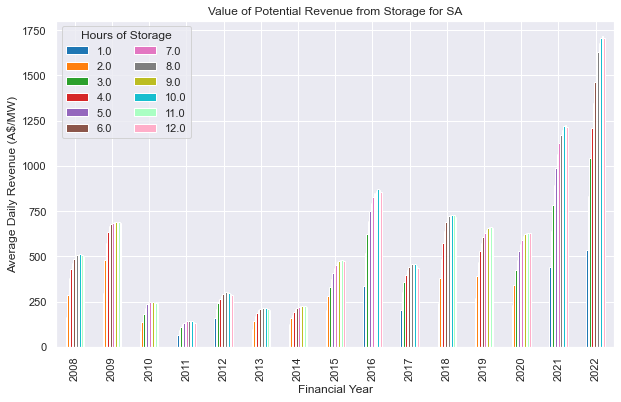

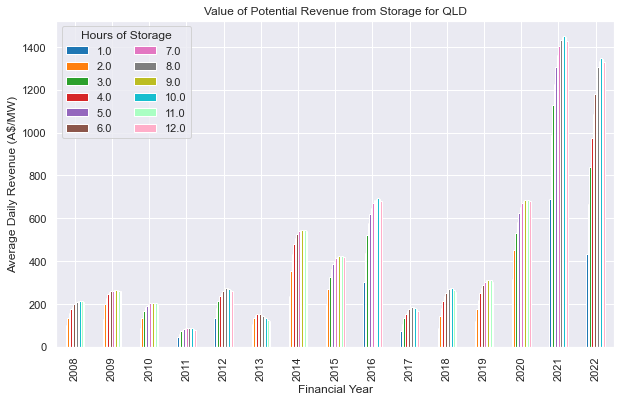

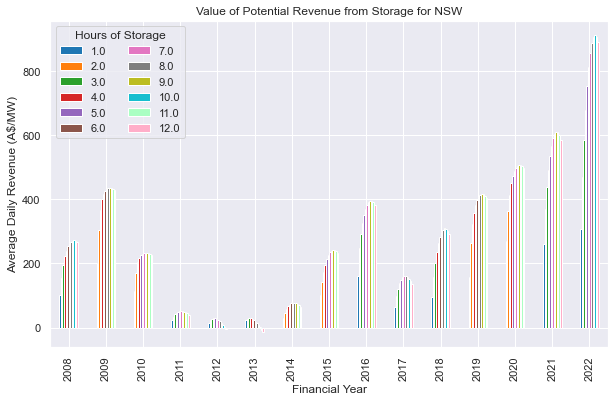

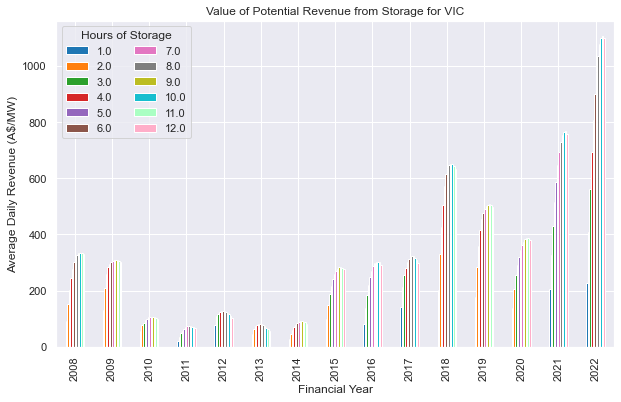

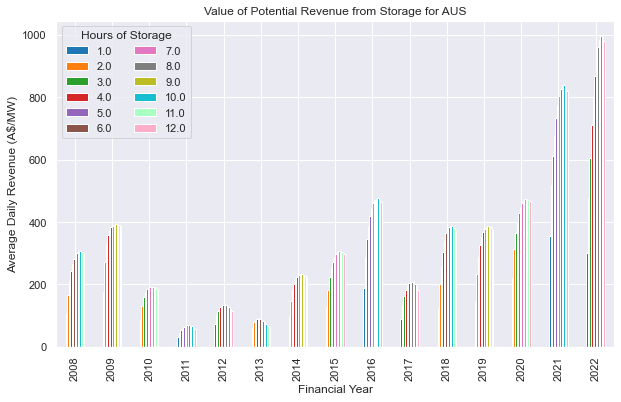

In [5]:
financial_year = True
years = 15
yearlyRevenuePlot(regions_aus, financial_year, years)
# Outputs:
# TAS_YtR - yearly total revenue calculation for n = 0.5 to n = 12 storage capacity

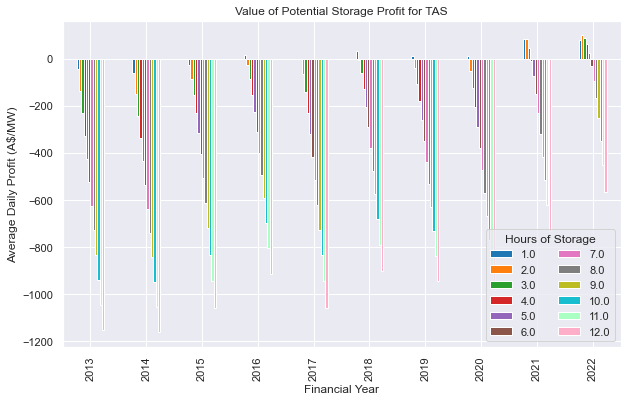

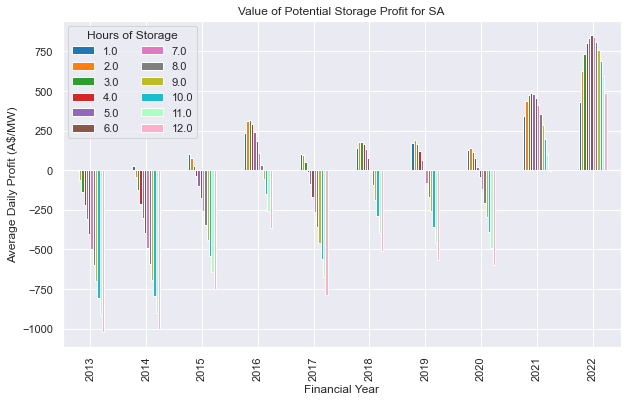

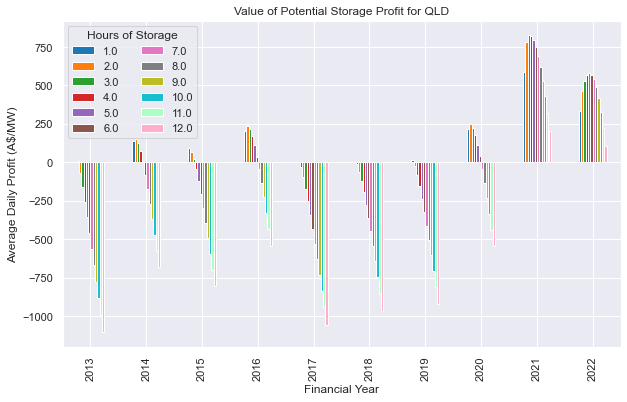

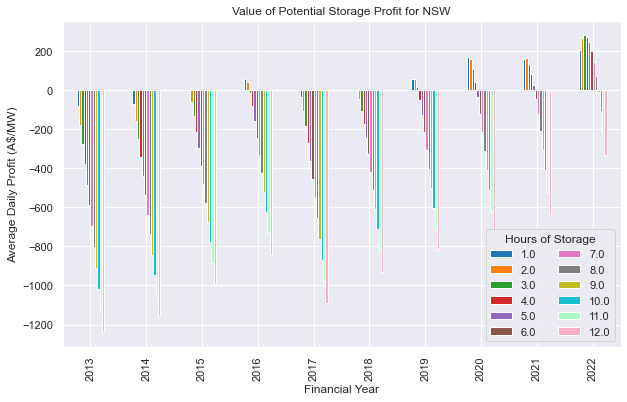

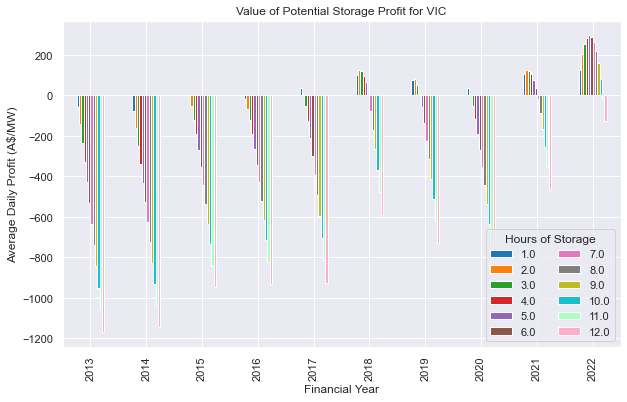

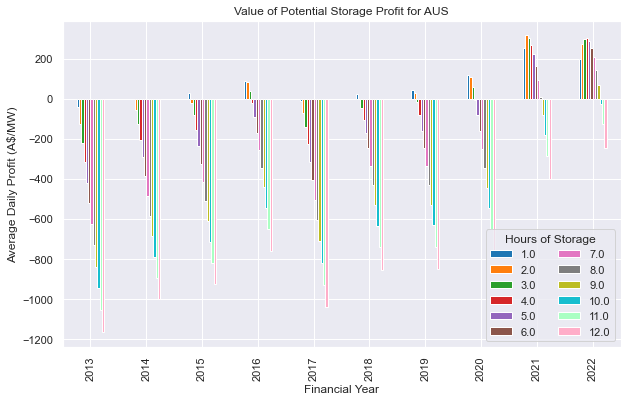

In [58]:
financial_year = True
lcos = 120*0.85
yearlyProfitPlot(regions_aus, financial_year, 10, lcos)
# Outputs:
# TAS_YtR - yearly total revenue calculation for n = 0.5 to n = 12 storage capacity

In [130]:
df = NSW.copy()
df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])

# Set 'timestamp' as the DataFrame index
df
daily_price_diff = df.groupby(df['SETTLEMENTDATE'].dt.date)['RRP'].agg(['min', 'max', 'count'])
daily_price_diff['time_diff'] = (daily_price_diff['max'] - daily_price_diff['min']).dt.total_seconds() / 60  # Convert to minutes
daily_price_diff

AttributeError: Can only use .dt accessor with datetimelike values

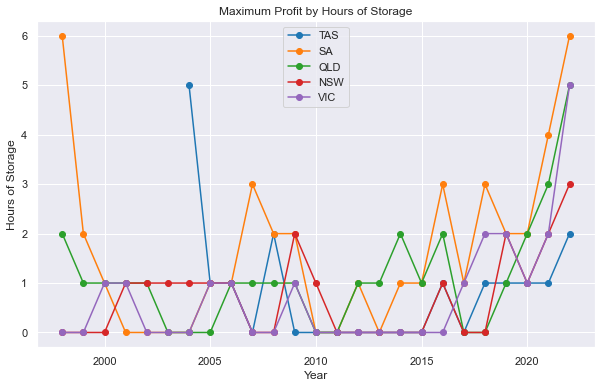

In [59]:
plt.figure(figsize=(10, 6))
width = 0.2  # Width of each bar

for i, df_name in enumerate(regions):
    df = globals()[df_name + '_YtP']
    #years = [int(year) for year in df.index]

    # Create a list to store the column index with the largest number for each year
    largest_column_indices = []

    # Create a list of column names in the original order
    column_names = df.columns.tolist()

    # Iterate through each year
    for year in df.index:
        # Find the column index with the largest number for the current year
        largest_value = df.loc[year].max()

        largest_column_index = df.loc[year].idxmax()

        # Find the position of the largest_column_index in the original column order
        largest_column_position = column_names.index(largest_column_index)

        
                # If the largest value is less than zero, set the largest column index to 0
        if largest_value < 0:
            largest_column_display = 0
        else:
            # Find the column index with the largest number for the current year
            largest_column_display = largest_column_position + 1

        largest_column_indices.append(largest_column_display)

    # Create a new DataFrame with years and corresponding largest column indices
    result_df = pd.DataFrame({'Year': df.index, 'Largest_Column_Index': largest_column_indices})

    # Plot the results
    #plt.bar(result_df['Year'], result_df['Largest_Column_Index'], label=df_name, alpha=0.6)
    #plt.scatter([int(year) for year in df.index], largest_column_indices, label=df_name)
    # Calculate bar positions
    #bar_positions = np.arange(len(years)) + i * width

    # Plot the results as an unstacked bar graph
    #plt.bar(bar_positions, largest_column_indices, width=width, label=df_name)


    plt.plot(result_df['Year'], result_df['Largest_Column_Index'], marker='o', label=df_name)
plt.xlabel('Year')
plt.ylabel('Hours of Storage')
plt.legend()
plt.title('Maximum Profit by Hours of Storage')
plt.grid(True)
plt.show()

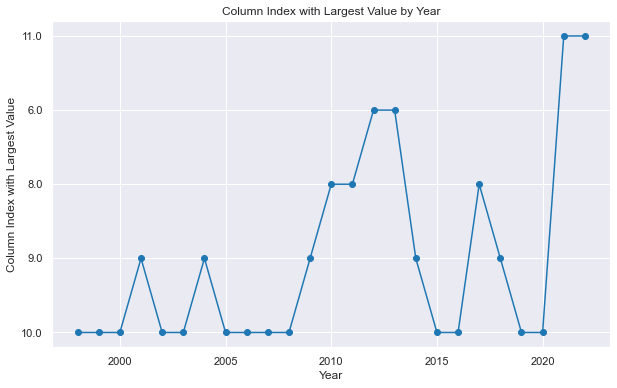

In [10]:
# Create a list to store the column index with the largest number for each year
largest_column_indices = []

# Iterate through each year
for year in VIC_YtR.index:
    # Find the column index with the largest number for the current year
    largest_column_index = VIC_YtR.loc[year].idxmax()
    largest_column_indices.append(largest_column_index)

# Create a new DataFrame with years and corresponding largest column indices
result_df = pd.DataFrame({'Year': VIC_YtR.index, 'Largest_Column_Index': largest_column_indices})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(result_df['Year'], result_df['Largest_Column_Index'], marker='o')
plt.xlabel('Year')
plt.ylabel('Column Index with Largest Value')
plt.title('Column Index with Largest Value by Year')
plt.grid(True)
plt.show()


Text(0, 0.5, 'Hours')

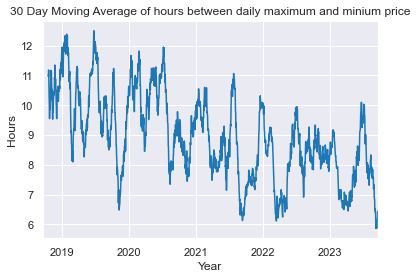

In [149]:
df = VIC
result = df.resample('D').apply(lambda x: abs((x['RRP'].idxmax() - x['RRP'].idxmin()).total_seconds() / 60 / 60))
result.tail(365*5).rolling(window=30).mean().plot()
plt.title('30 Day Moving Average of hours between daily maximum and minium price')
plt.xlabel('Year')
plt.ylabel('Hours')

Text(0, 0.5, 'Hours')

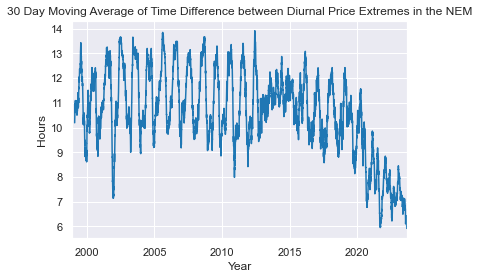

In [161]:
df = AUS
df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
df.set_index('SETTLEMENTDATE', inplace=True)

result = df.resample('D').apply(lambda x: abs((x['RRP'].idxmax() - x['RRP'].idxmin()).total_seconds() / 60 / 60))
result.rolling(window=60).mean().plot()
plt.title('30 Day Moving Average of Time Difference between Diurnal Price Extremes in the NEM')
plt.xlabel('Year')
plt.ylabel('Hours')

No handles with labels found to put in legend.


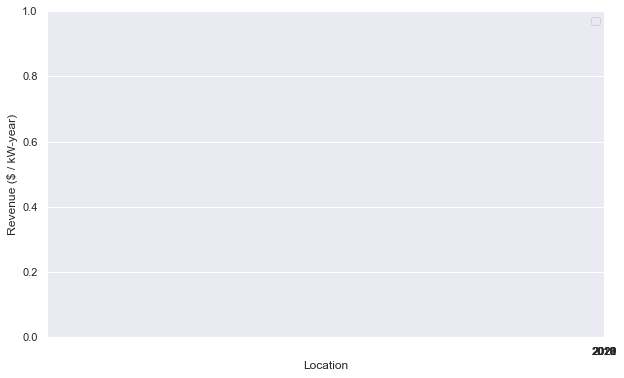

In [64]:
years = 5
#plt.figure(figsize=(10, 6))  # Create the main figure outside the loop
combined_df = pd.DataFrame()

bar_width = 0.2  # Adjust the width of each bar as needed
for i, df_name in enumerate(regions):
    df = globals()[df_name + '_YtR']
    df2 = df['9.0']
    df2 = df2.tail(years)
    #x_values = df2.index + i * (bar_width)  # Add an offset for each region
    #plt.bar(x_values, df2, width=bar_width, label=df_name)
    combined_df = pd.concat([combined_df, df2], axis=1)
combined_df.columns = regions

# Customize the plot
plt.xlabel('Location')
plt.ylabel('Revenue ($ / kW-year)')
plt.legend()
plt.grid(True)

# Adjust the x-axis ticks for better readability (optional)
plt.xticks(df2.index + (len(regions) - 1) * (bar_width) / 2, df2.index)

# Display the plot
plt.show()

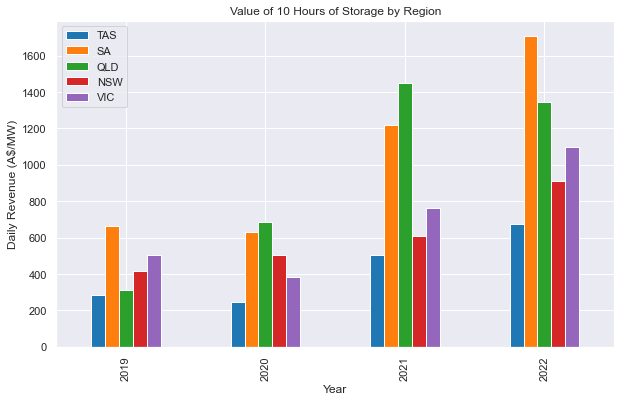

In [104]:
years = 4
combined_df = pd.DataFrame()
for i, df_name in enumerate(regions):
    df = globals()[df_name + '_YtR']
    df2 = df['10.0']
    df2 = df2.tail(years)
    combined_df = pd.concat([combined_df, df2], axis=1)
combined_df.columns = regions

combined_df.plot(kind="bar", figsize=(10, 6))
plt.title('Value of 10 Hours of Storage by Region')
plt.xlabel('Year')
plt.ylabel('Daily Revenue (A$/MW)')
plt.legend()
plt.grid(True)

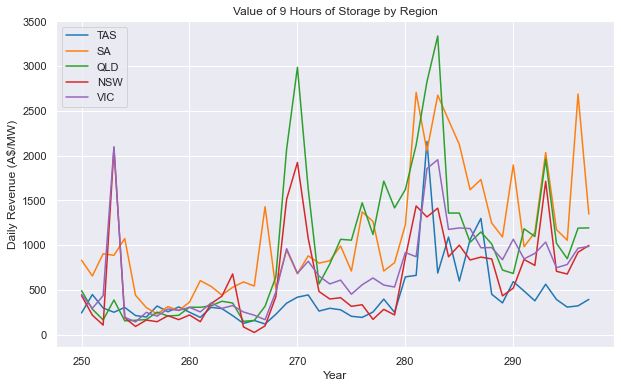

In [41]:
years = 12*4
combined_df = pd.DataFrame()
for i, df_name in enumerate(regions):
    df = globals()[df_name + '_aMR']
    df2 = df['hours=9.0']
    df2 = df2.tail(years)
    combined_df = pd.concat([combined_df, df2], axis=1)
combined_df.columns = regions

combined_df['TAS'] = combined_df['TAS'].shift(years)

# Delete the first n rows
combined_df = combined_df.iloc[n:]

combined_df.plot(figsize=(10, 6))
plt.title('Value of 9 Hours of Storage by Region')
plt.xlabel('Year')
plt.ylabel('Daily Revenue (A$/MW)')
plt.legend()
plt.grid(True)

In [ ]:
x = df2.index
indexes = np.argsort(so_oppo_df.values).T
widths = np.sort(so_oppo_df.values).T
order = -1
lefts = widths[::order].cumsum(axis=0)
lefts = np.insert(lefts, 0, np.zeros(len(lefts[0])), axis=0)

mpp_colors = dict(zip(so_oppo_df.columns, plt.cm.get_cmap("tab20c").colors))

for k, (idxs, vals) in enumerate(list(zip(indexes, widths))[::order]):
    mps = np.take(np.array(so_oppo_df.columns), idxs)
    ax1.barh(x, width=vals, left=lefts[k], color=[mpp_colors[m] for m in mps])

ax1.legend((np.take(np.array(so_oppo_df.columns), np.argsort(so_oppo_df.values)[0]))[::-1], bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
ax1.title.set_text(f"Team Opposition - 5v5 Sorted TOI")

In [380]:
marginal_revenue_increase = AUS_YtR.diff(axis=1)

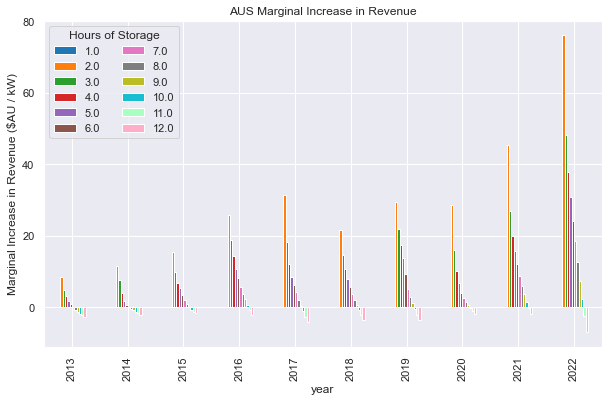

In [386]:
marginal_revenue_increase.tail(10).plot.bar(figsize=(10, 6))
y_label = 'Marginal Increase in Revenue ($AU / kW)' 

# Set plot labels and title
plt.ylabel(y_label)
plt.title('AUS Marginal Increase in Revenue')
plt.legend(title='Hours of Storage', ncol=2)
plt.grid(True)
plt.show()  

1.0     37.61
2.0     55.78
3.0     68.55
4.0     78.41
5.0     85.90
6.0     91.53
7.0     95.63
8.0     98.32
9.0     99.71
10.0    99.86
11.0    98.83
12.0    96.67
dtype: float64


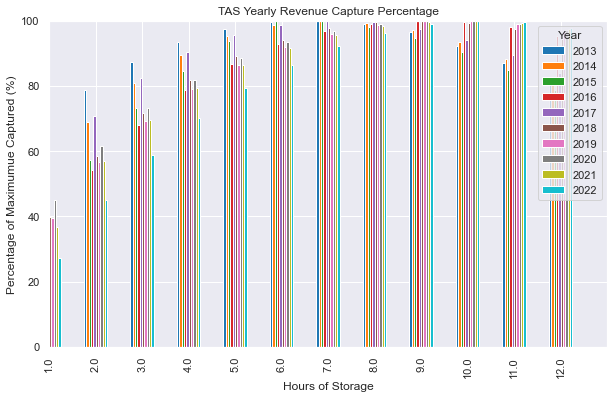

1.0     35.54
2.0     53.24
3.0     65.79
4.0     75.57
5.0     83.50
6.0     89.53
7.0     93.76
8.0     96.78
9.0     98.75
10.0    99.77
11.0    99.86
12.0    99.03
dtype: float64


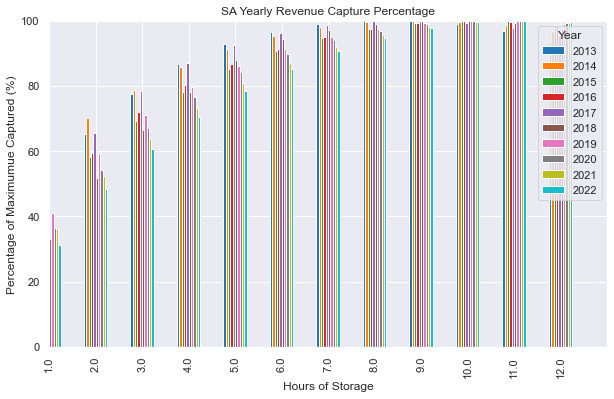

1.0     39.23
2.0     58.40
3.0     70.73
4.0     79.86
5.0     86.90
6.0     92.27
7.0     96.10
8.0     98.52
9.0     99.72
10.0    99.87
11.0    99.08
12.0    97.45
dtype: float64


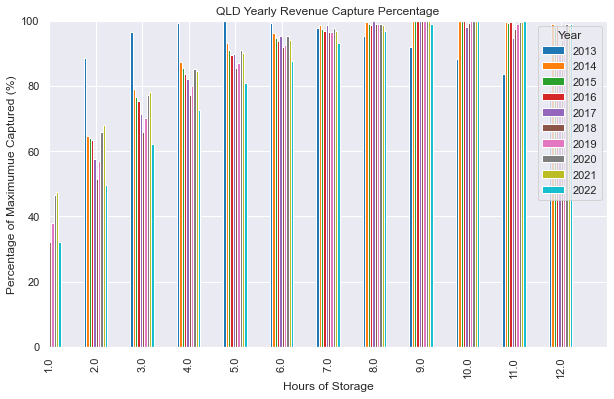

1.0     39.81
2.0     59.59
3.0     72.04
4.0     81.22
5.0     88.15
6.0     93.18
7.0     96.69
8.0     98.88
9.0     99.88
10.0    99.79
11.0    98.67
12.0    96.62
dtype: float64


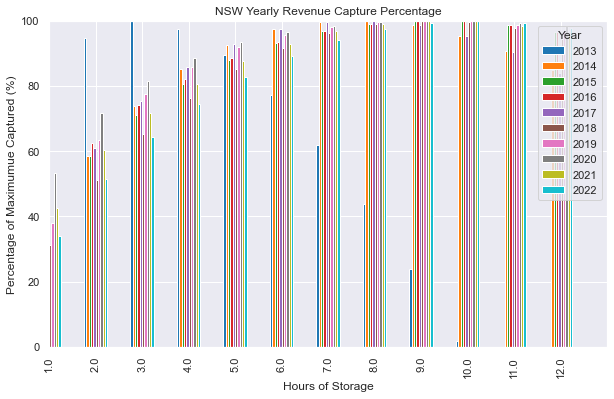

1.0     29.86
2.0     47.89
3.0     61.72
4.0     73.04
5.0     82.09
6.0     88.73
7.0     93.43
8.0     96.77
9.0     98.88
10.0    99.82
11.0    99.66
12.0    98.45
dtype: float64


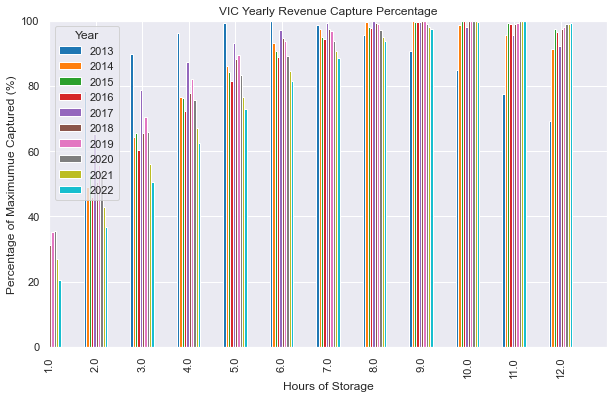

1.0     37.80
2.0     57.56
3.0     70.23
4.0     79.75
5.0     87.17
6.0     92.53
7.0     96.13
8.0     98.48
9.0     99.70
10.0    99.87
11.0    99.08
12.0    97.39
dtype: float64


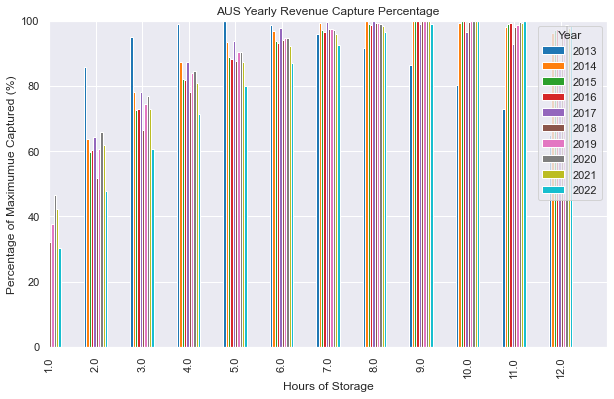

In [105]:
marginalBenefitPlot(regions_aus)

2018
7026   2018-03-03
7052   2018-03-29
7012   2018-02-17
7020   2018-02-25
7034   2018-03-11
7040   2018-03-17
7036   2018-03-13
7047   2018-03-24
7035   2018-03-12
Name: date, dtype: datetime64[ns]
2018
7040   2018-03-17
7052   2018-03-29
7030   2018-03-07
7036   2018-03-13
7020   2018-02-25
7075   2018-04-21
7034   2018-03-11
7043   2018-03-20
7035   2018-03-12
Name: date, dtype: datetime64[ns]
2018
7040   2018-03-17
6979   2018-01-15
7030   2018-03-07
7036   2018-03-13
7020   2018-02-25
7034   2018-03-11
7075   2018-04-21
7043   2018-03-20
7035   2018-03-12
Name: date, dtype: datetime64[ns]
2020
7852   2020-06-06
7910   2020-08-03
7999   2020-10-31
7787   2020-04-02
7706   2020-01-12
7828   2020-05-13
7779   2020-03-25
7781   2020-03-27
7747   2020-02-22
7702   2020-01-08
Name: date, dtype: datetime64[ns]
2020
7852   2020-06-06
7706   2020-01-12
7787   2020-04-02
7999   2020-10-31
7778   2020-03-24
7781   2020-03-27
7747   2020-02-22
7828   2020-05-13
7702   2020-01-08
7779   2020

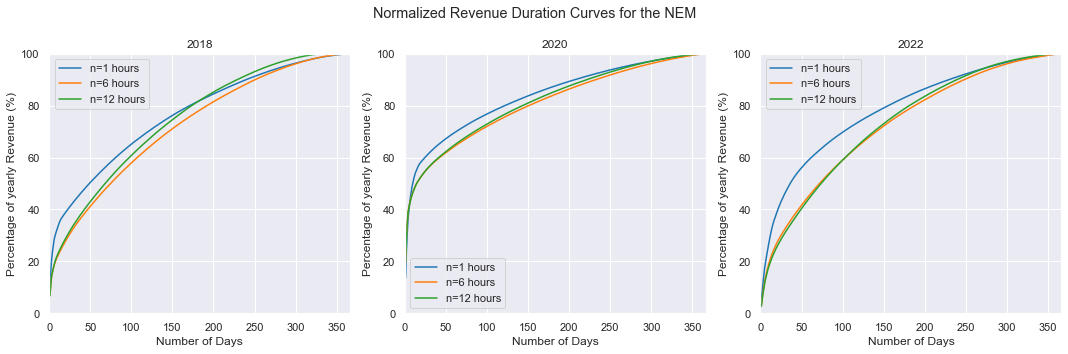

In [92]:
revenueDurationPlot2('AUS', [1, 6, 12])

2019
7691   2019-12-28
7356   2019-01-27
7335   2019-01-06
7674   2019-12-11
7443   2019-04-24
7673   2019-12-10
7685   2019-12-22
7382   2019-02-22
7687   2019-12-24
Name: date, dtype: datetime64[ns]
2019
7380   2019-02-20
7635   2019-11-02
7410   2019-03-22
7443   2019-04-24
7335   2019-01-06
7687   2019-12-24
7432   2019-04-13
7415   2019-03-27
7382   2019-02-22
Name: date, dtype: datetime64[ns]
2020
7852   2020-06-06
7910   2020-08-03
7999   2020-10-31
7787   2020-04-02
7706   2020-01-12
7828   2020-05-13
7779   2020-03-25
7781   2020-03-27
7747   2020-02-22
7702   2020-01-08
Name: date, dtype: datetime64[ns]
2020
7894   2020-07-18
7780   2020-03-26
7999   2020-10-31
7747   2020-02-22
7778   2020-03-24
7702   2020-01-08
7787   2020-04-02
7828   2020-05-13
7781   2020-03-27
7779   2020-03-25
Name: date, dtype: datetime64[ns]
2021
8092   2021-02-01
8111   2021-02-20
8078   2021-01-18
8139   2021-03-20
8067   2021-01-07
8080   2021-01-20
8088   2021-01-28
8095   2021-02-04
8099   2021

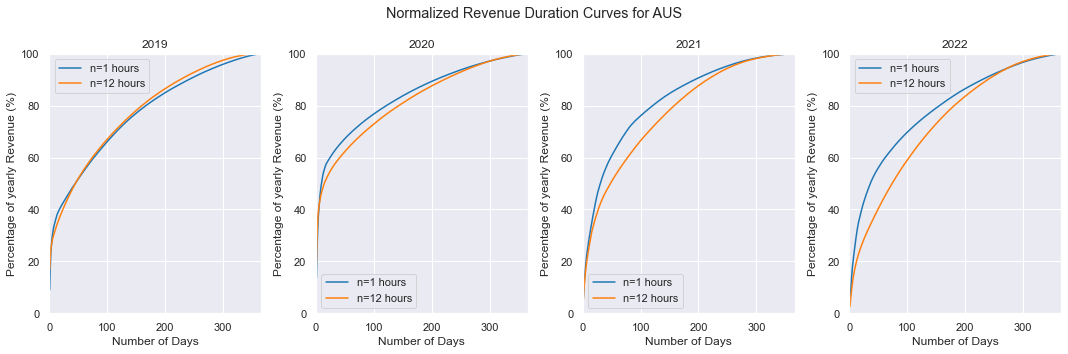

In [164]:
revenueDurationPlot2('AUS', [1, 12])

In [94]:
#seasonalPlots(regions)

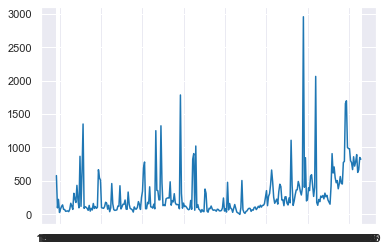

In [167]:
plt.plot(VIC_aMR['month'], VIC_aMR['hours=9.0'], label='Avg. Monthly Revenue')

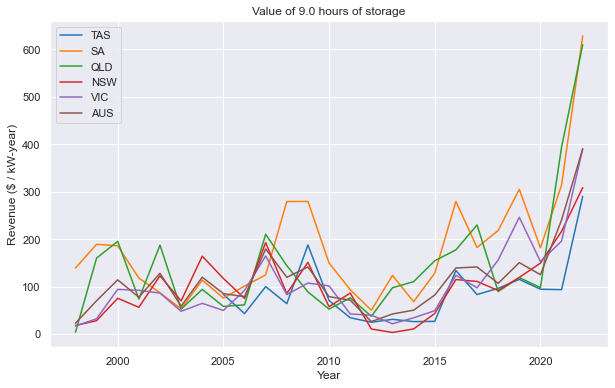

In [145]:
valueStoragePlot(regions_aus, 9)

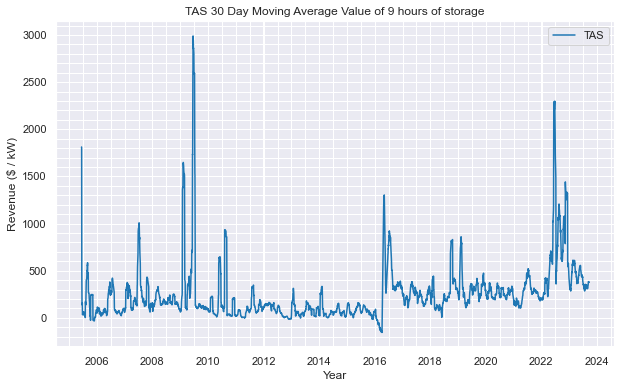

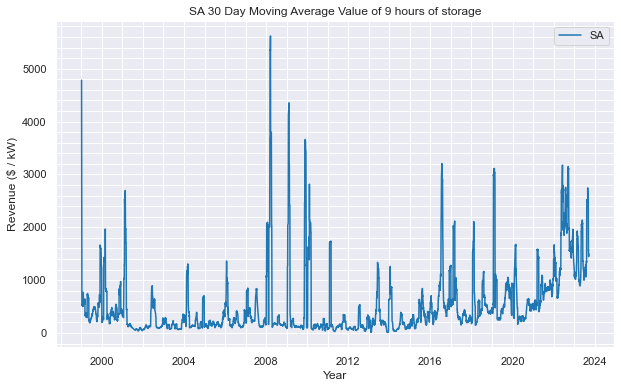

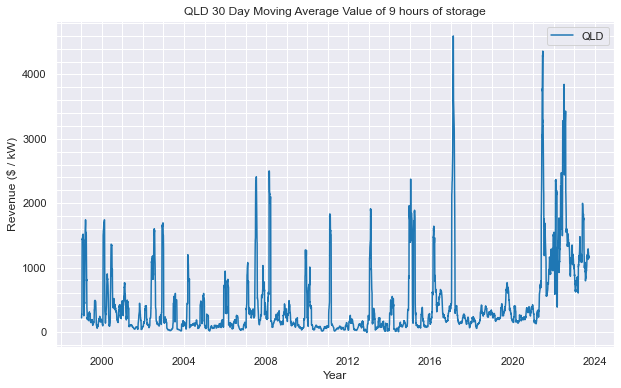

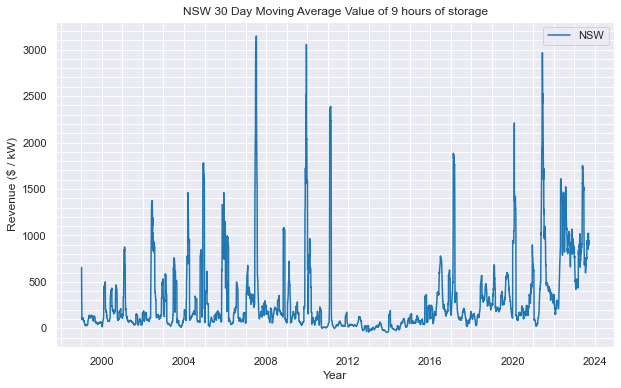

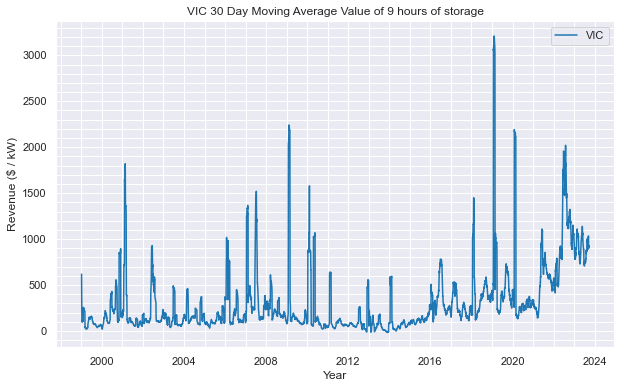

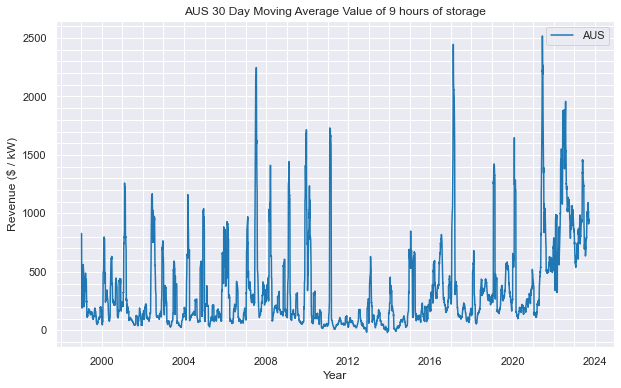

In [146]:
ValuePlotMA(regions_aus, 30, 9)

In [145]:
# Convert the index of VIC_aMR to Timestamps

hour = 6

for df_name in regions:
    df = globals()[df_name + '_aMR']
    df['month'] = pd.to_datetime(df['month'])

    df.index = df['month']

    # Calculate the number of months from the latest date
    df['months_passed'] = (df['month'] - df['month'].max())  # Approximate months in a year

    # Define an interest rate (example: 5% annually)
    interest_rate = 0.05

    hoursStr = 'hours=' + str(hour) + '.0'
    # Calculate present value using compound interest formula: PV = FV / (1 + r)^n
    df['present_value'] = df[hoursStr] / (1 + interest_rate) ** (df['months_passed'] / 12)

    # Plot the data
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

    pltLabel = 'Present Value (' + str(interest_rate*100) + '%)'
    # Plot present value and revenue
    plt.plot(df.index, df['present_value'], label=pltLabel)
    plt.plot(df.index, df[hoursStr], label='Revenue')

    # Customize the plot
    plt.title(df_name + ' Value of 6 hours of storage accounting for inflation')
    plt.xlabel('Date')
    plt.ylabel('Revenue ($ / kW)')
    plt.legend()
    plt.grid(True, which='minor')

    # Display the plot
    plt.show()

KeyError: 'month'

Correlation Coefficient (r) = 0.79


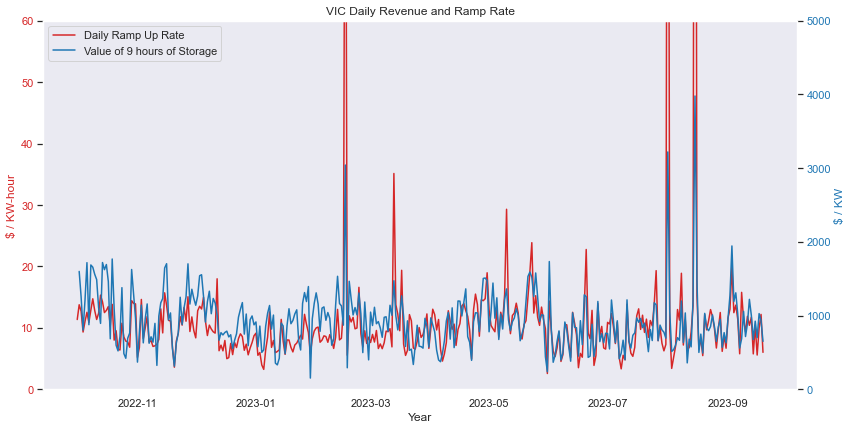

In [150]:
hoursStorage = 9
transparency = 1
yearsBack = 1
MAlength = 1
grouped = diurnal_slope(['VIC'], MAlength, hoursStorage, transparency, yearsBack, False)

In [288]:
df = on_VIC

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.strftime('%Y-%m')
df['GWH'] = df.iloc[:, 1:12].sum(axis=1)
df['%vre'] = df.iloc[:, 9:12].sum(axis=1) / df['GWH'] * 100
df['solar'] = df['Solar (Utility) -  GWh'] + df['Solar (Rooftop) -  GWh']
df['%solar'] = df['solar'] / df['GWH'] * 100
df['%coal']= df['Coal (Brown) -  GWh'] / df['GWH'] * 100
df['date'] = pd.to_datetime(df['date'])
df['%battery'] = df['Battery (Discharging) -  GWh']/ df['GWH'] * 100
df['%batteryCharge'] = df['Battery (Charging) -  GWh']/ df['GWH'] * 100

Number of days in August 2023 with negative prices in VIC: 5


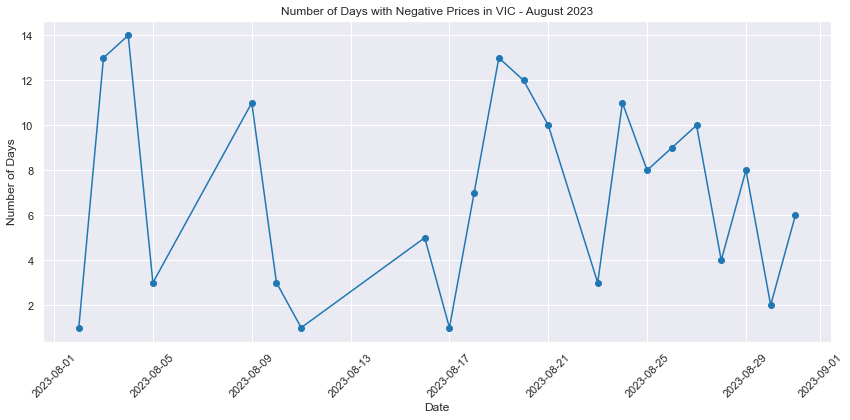

In [17]:
data = AUS

# Filter data for August 2023
august_2023_data = data[(data['SETTLEMENTDATE'].dt.year == 2019) & (data['SETTLEMENTDATE'].dt.month == 8)]

# Create a Boolean mask for negative prices
negative_price_mask = august_2023_data['RRP'] < 0

# Use groupby to count the number of days with negative prices
days_with_negative_prices = august_2023_data[negative_price_mask].groupby(august_2023_data['SETTLEMENTDATE'].dt.date).size()

# Print the count of days with negative prices
print("Number of days in August 2023 with negative prices in VIC:", len(days_with_negative_prices))

data['neg'] = data['RRP'] < 0

# Group by date and count the number of days with negative prices
daily_counts = august_2023_data[negative_price_mask].groupby(august_2023_data['SETTLEMENTDATE'].dt.date).size()

# Create a time series for each day
time_series = pd.to_datetime(daily_counts.index)

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(time_series, daily_counts, marker='o', linestyle='-')
plt.title("Number of Days with Negative Prices in VIC - August 2023")
plt.xlabel("Date")
plt.ylabel("Number of Days")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

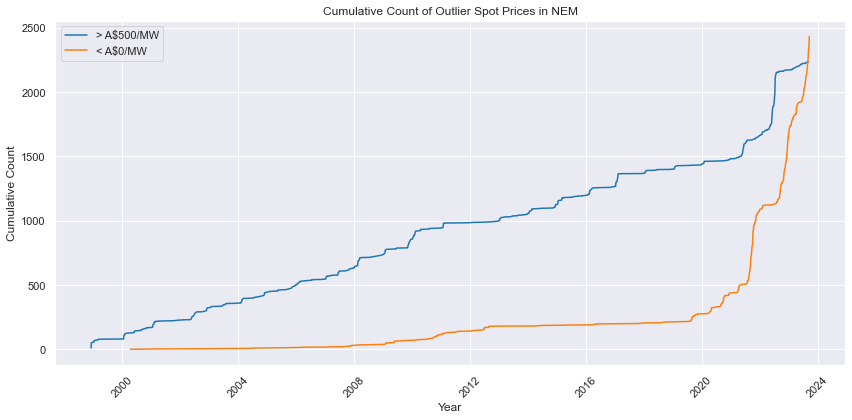

In [96]:
# Create a Boolean mask for negative prices
data = AUS
price_mask = (data['RRP'] > 500)# | (data['RRP'] < 0)
negative_price_mask = (data['RRP'] < 0)

# Group by date and count the number of days with negative prices
daily_counts = data[price_mask].groupby(data['SETTLEMENTDATE'].dt.date).size()
daily_counts2 = data[negative_price_mask].groupby(data['SETTLEMENTDATE'].dt.date).size()

# Create a time series for each day
time_series = pd.to_datetime(daily_counts.index)
time_series2 = pd.to_datetime(daily_counts2.index)

# Create a cumulative sum of daily counts to track the increasing total
#daily_counts[daily_counts > 1] = 1

cumulative_counts = daily_counts.cumsum()
cumulative_counts2 = daily_counts2.cumsum()

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(time_series, cumulative_counts, linestyle='-', label='> A$500/MW')
plt.plot(time_series2, cumulative_counts2, linestyle='-', label='< A$0/MW')

plt.title("Cumulative Count of Outlier Spot Prices in NEM")
plt.xlabel("Year")
plt.ylabel("Cumulative Count")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [54]:
daily_counts = data[negative_price_mask].groupby(data['SETTLEMENTDATE'].dt.date).size()
daily_counts[daily_counts > 1] = 1
daily_counts
daily_counts

SETTLEMENTDATE
2000-04-15    1
2000-10-22    1
2000-10-28    1
2002-01-03    1
2002-11-03    1
             ..
2023-09-15    1
2023-09-16    1
2023-09-17    1
2023-09-18    1
2023-09-19    1
Length: 471, dtype: int64

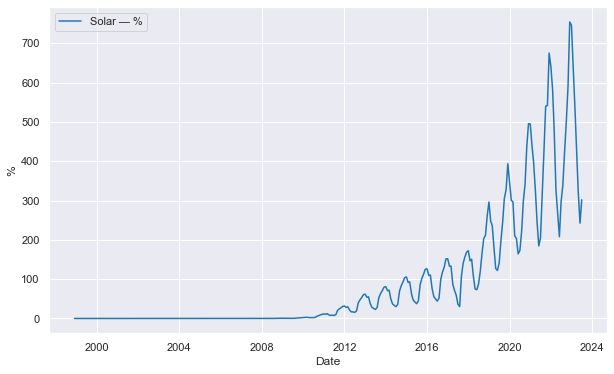

In [148]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['solar'], label='Solar — %')
plt.xlabel('Date')
plt.ylabel('%')
plt.legend()
plt.grid(True, which='major')
plt.show()

cumulative_counts[-1]

In [41]:
last_max_index = cumulative_counts.idxmax()
last_max_value = cumulative_counts[last_max_index]

print("Last Max Value in cumulative_counts:", last_max_value)
print("Corresponding Index (Date):", last_max_index)

Last Max Value in cumulative_counts: 2433
Corresponding Index (Date): 2023-09-19 00:00:00


In [47]:
target_date = '2023-09-19'

# Find the count on January 1, 2020
count_on_target_date = cumulative_counts.get(target_date, 0)

print("Count on January 1, 2020:", count_on_target_date)

Count on January 1, 2020: 2433


In [43]:
cumulative_counts.index = pd.to_datetime(cumulative_counts.index)

# Find the count on January 1, 2020
count_on_january_1_2020 = cumulative_counts.loc['2020-01-02 00:00:00']

print("Count of Days with Negative Prices on January 1, 2020:", count_on_january_1_2020)

KeyError: '2020-01-02 00:00:00'

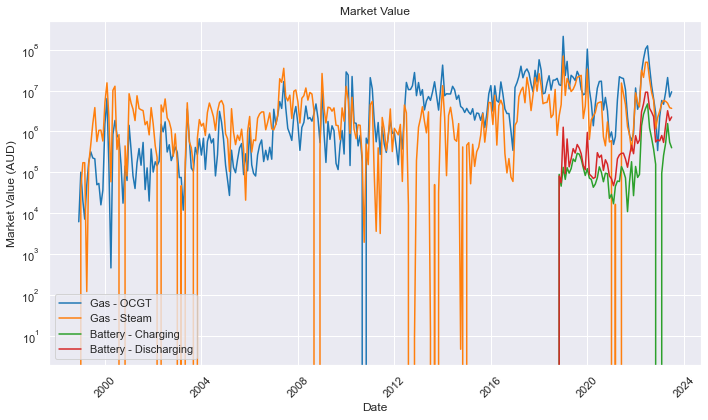

In [149]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['Gas (OCGT) Market Value - AUD'], label='Gas - OCGT')
plt.plot(df['date'], df['Gas (Steam) Market Value - AUD'], label='Gas - Steam')
plt.plot(df['date'], df['Battery (Charging) Market Value - AUD'], label='Battery - Charging')
plt.plot(df['date'], df['Battery (Discharging) Market Value - AUD'], label='Battery - Discharging')

plt.xlabel('Date')
plt.ylabel('Market Value (AUD)')
plt.yscale("log")
plt.title('Market Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

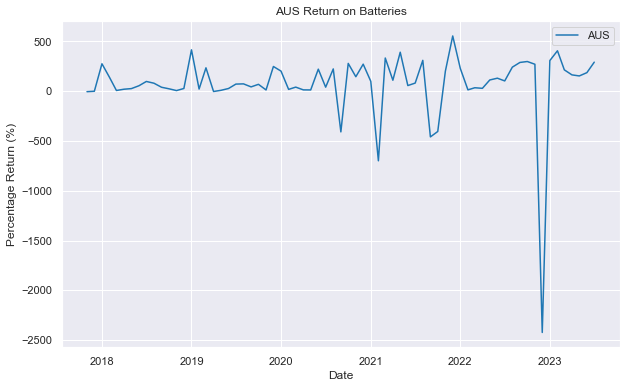

In [349]:
plt.figure(figsize=(10, 6))

regions = ['AUS']#, 'SA', 'QLD', 'NSW', 'VIC']
for dr_name in regions:
    globals()["on_" + dr_name]['date'] = pd.to_datetime(globals()["on_" + dr_name]['date'])
    
    globals()["on_" + dr_name]['Battery Returns'] = (globals()["on_" + dr_name]['Battery (Discharging) Market Value - AUD'] - globals()["on_" + dr_name]['Battery (Charging) Market Value - AUD']) / globals()["on_" + dr_name]['Battery (Charging) Market Value - AUD'] * 100
    #if globals()["on_" + dr_name]['Battery (Discharging) Market Value - AUD'] < globals()["on_" + dr_name]['Battery (Charging) Market Value - AUD']:
        #print(globals()["on_" + dr_name][globals()["on_" + dr_name]['Battery (Discharging) Market Value - AUD'] < globals()["on_" + dr_name]['Battery (Charging) Market Value - AUD']])
    plt.plot(globals()["on_" + dr_name]['date'], globals()["on_" + dr_name]['Battery Returns'], label=dr_name)

plt.xlabel('Date')
plt.ylabel('Percentage Return (%)')
plt.title('AUS Return on Batteries')
plt.legend()
plt.grid(True)
plt.show()

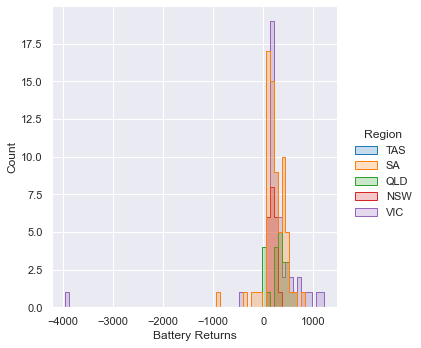

In [151]:
combined_df = pd.concat([on_TAS, on_SA, on_QLD, on_NSW, on_VIC], keys=['TAS', 'SA', 'QLD', 'NSW', 'VIC'])
# Reset the index to separate the species
combined_df = combined_df.reset_index(level=0).rename(columns={'level_0': 'Region'})
combined_df = combined_df[~np.isinf(combined_df['Battery Returns'])]

sb.displot(combined_df, x="Battery Returns (%)", hue="Region",  element="step")#, multiple="stack")

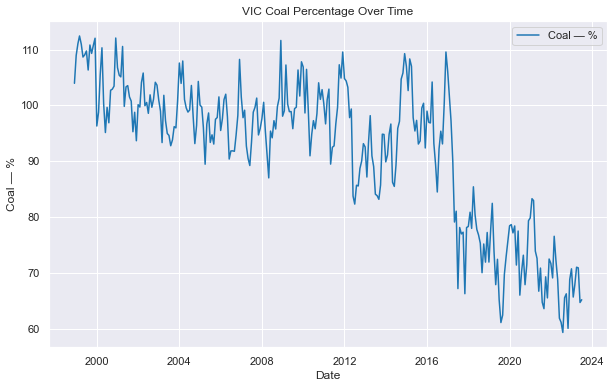

In [154]:
df = on_VIC

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['%coal'], label='Coal — %')
plt.xlabel('Date')
plt.ylabel('Coal — %')
plt.title('VIC Coal Percentage Over Time')
plt.legend()
plt.grid(True)
plt.show()

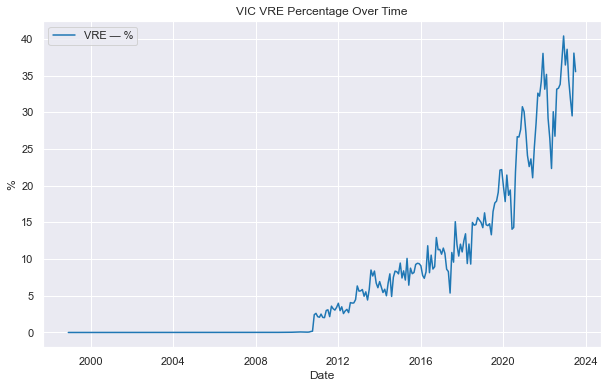

In [155]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['%vre'], label='VRE — %')
plt.xlabel('Date')
plt.ylabel('%')
plt.title('VIC VRE Percentage Over Time')
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'Battery Returns'

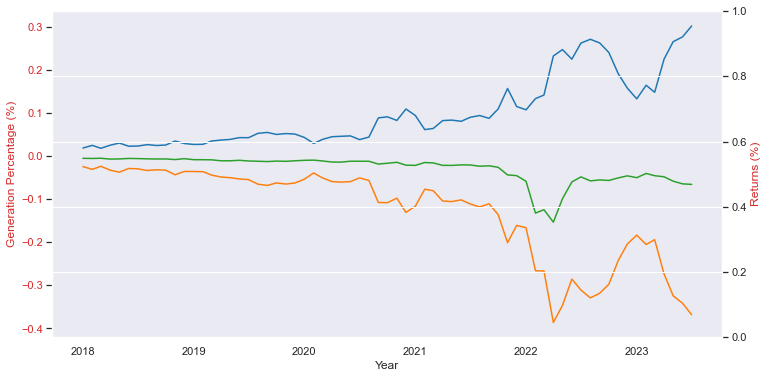

In [38]:
df = on_AUS

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.strftime('%Y-%m')
df['GWH'] = df.iloc[:, 1:12].sum(axis=1)
df['%vre'] = df.iloc[:, 9:12].sum(axis=1) / df['GWH'] * 100
df['solar'] = df['Solar (Utility) -  GWh'] + df['Solar (Rooftop) -  GWh']
df['%solar'] = df['solar'] / df['GWH'] * 100
df['%coal']= df['Coal (Brown) -  GWh'] / df['GWH'] * 100
df['date'] = pd.to_datetime(df['date'])
df['%battery'] = df['Battery (Discharging) -  GWh']/ df['GWH'] * 100
df['%batteryCharge'] = df['Battery (Charging) -  GWh']/ df['GWH'] * 100

fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Generation Percentage (%)', color=color)
df = df[df['date'].dt.year >= 2018]
lns1 = plt.plot(df['date'], df['%battery'], label='Battery Discharging')
lns2 = plt.plot(df['date'], df['%batteryCharge'], label='Battery Charging')
lns4 = plt.plot(df['date'], df['%batteryCharge'] + df['%battery'], label='Battery Charging Differential')


ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Returns (%)', color=color)  # we already handled the x-label with ax1
lns3 = ax2.plot(df['date'], df['Battery Returns']*100, label='Battery Returns', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

lns = lns3+lns2+lns1+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('VIC Battery Statistics')
plt.show()

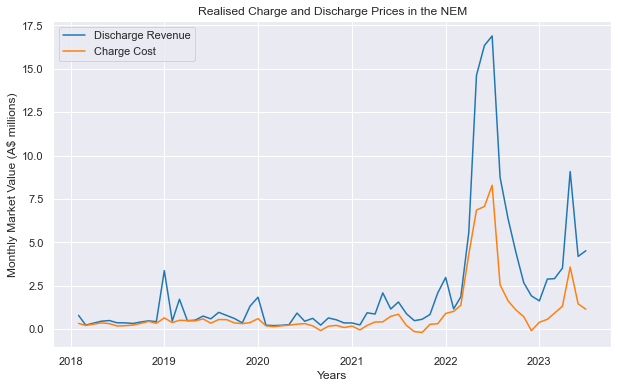

In [44]:
df = on_AUS
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.strftime('%Y-%m')
df['GWH'] = df.iloc[:, 1:12].sum(axis=1)
df['%vre'] = df.iloc[:, 9:12].sum(axis=1) / df['GWH'] * 100
df['solar'] = df['Solar (Utility) -  GWh'] + df['Solar (Rooftop) -  GWh']
df['%solar'] = df['solar'] / df['GWH'] * 100
df['%coal']= df['Coal (Brown) -  GWh'] / df['GWH'] * 100
df['date'] = pd.to_datetime(df['date'])
df['%battery'] = df['Battery (Discharging) -  GWh']/ df['GWH'] * 100
df['%batteryCharge'] = df['Battery (Charging) -  GWh']/ df['GWH'] * 100

plt.figure(figsize=(10, 6))
plt.plot(df['date'].tail(66), df['Battery (Discharging) Market Value - AUD'].tail(66)/1000000, label='Discharge Revenue')
plt.plot(df['date'].tail(66), df['Battery (Charging) Market Value - AUD'].tail(66)/1000000, label='Charge Cost')
#plt.plot(df['date'], df['Battery (Discharging) Market Value - AUD']/1000000 - df['Battery (Charging) Market Value - AUD']/1000000, label='Gross Profit')
#plt.plot(df['date'], (df['Battery (Discharging) Market Value - AUD']/1000000 - df['Battery (Charging) Market Value - AUD']/1000000) / abs(df['Battery (Charging) Market Value - AUD']/1000000), label='Gross Profit')
#plt.plot(df['date'], df['%battery']*10, label='Battery Discharging')
plt.legend()
plt.ylabel('Monthly Market Value (A$ millions)')
plt.xlabel('Years')
plt.title('Realised Charge and Discharge Prices in the NEM')
plt.legend()
plt.grid(True)
plt.show()



In [37]:
np.mean((df['Battery (Discharging) Market Value - AUD'] - df['Battery (Charging) Market Value - AUD']) / abs(df['Battery (Charging) Market Value - AUD'])*100)

195.9078779997866

<ipython-input-170-14da3b53c7df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VIC_aMR['month'] = pd.to_datetime(VIC_aMR['month'])


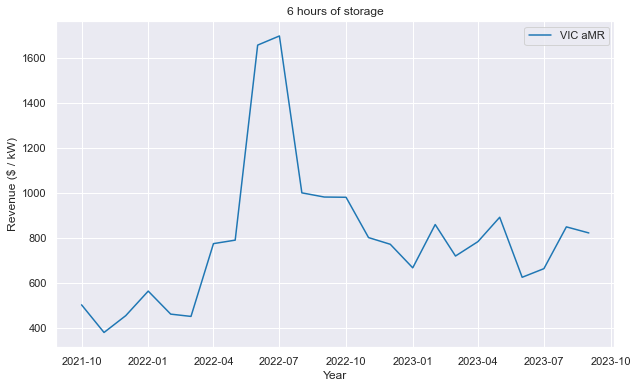

In [170]:
# Plot the data
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
VIC_aMR = VIC_aMR.tail(24)
VIC_aMR['month'] = pd.to_datetime(VIC_aMR['month'])
# Plot DataFrame 2
plt.plot(VIC_aMR['month'], VIC_aMR['hours=6.0'], label='VIC aMR')

# Customize the plot
plt.title('6 hours of storage')
plt.xlabel('Year')
plt.ylabel('Revenue ($ / kW)')
plt.legend()
plt.grid(True, which='minor')

# Display the plot
plt.show()


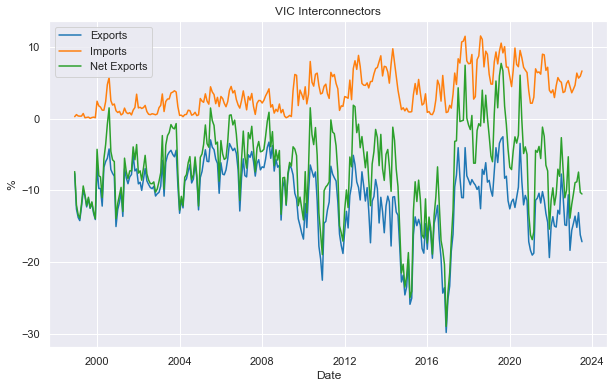

In [158]:
df = on_VIC
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['Exports -  GWh'] / on_VIC['GWH'] * 100 , label='Exports')
plt.plot(df['date'], df['Imports -  GWh'] / on_VIC['GWH'] * 100, label='Imports')
df['Net Exports'] = df['Exports -  GWh'] + df['Imports -  GWh']
plt.plot(df['date'], df['Net Exports'] / on_VIC['GWH'] * 100, label='Net Exports')

plt.xlabel('Date')
plt.ylabel('%')
plt.title('VIC Interconnectors')
plt.legend()
plt.show()

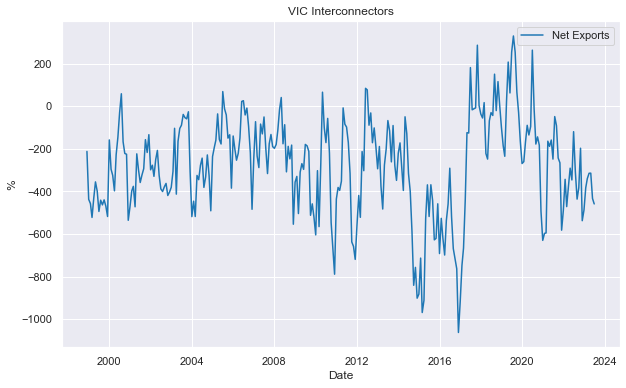

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['Net Exports'], label='Net Exports')
plt.xlabel('Date')
plt.ylabel('%')
plt.title('VIC Interconnectors')
plt.legend()
plt.show()

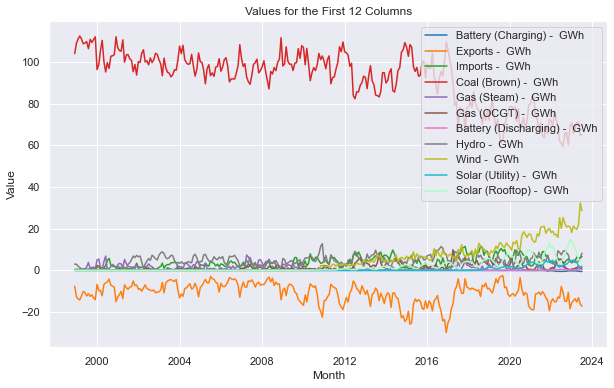

In [160]:
# Extract column names
column_names = on_VIC.columns[1:12] #on_VIC.columns[1:13]  # Exclude 'month'

# Create the plot
plt.figure(figsize=(10, 6))

# Loop through columns and plot them
for column in column_names:
    plt.plot(on_VIC['date'], (on_VIC[column] / on_VIC['GWH'] * 100), label=column)
#plt.plot(VIC_aMR['month'], VIC_aMR['hours=6.0'], label='VIC aMR')

# Add labels and legend
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Values for the First 12 Columns')
plt.legend()

# Display the plot
plt.show()